## Notebook to create figures for our report

In [1]:
import os
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from scr.pytorch_model_defs import WaterPlasticModel
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [3]:
# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
# train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
# test_images, test_labels = load_data_from_directory(test_dir)


In [4]:
# train_dataset = ImageDataset(train_images, train_labels, transform=None)
val_dataset = ImageDataset(val_images, val_labels, transform=None)
# test_dataset = ImageDataset(test_images, test_labels, transform=None)


In [5]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

train_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle only for training
    num_workers=4,      # Adjust based on your system
    pin_memory=True     # Speeds up GPU transfer if using CUDA
)

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,      # Typically no shuffle for validation
#     num_workers=4,
#     pin_memory=True
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,      # Typically no shuffle for test
#     num_workers=4,
#     pin_memory=True
# )


In [6]:
from collections import Counter
# Initialize a Counter to store the class counts
class_counts = Counter()

# Iterate through the DataLoader and count labels
for _, labels in train_loader:
    class_counts.update(labels.tolist())

# Print the results
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label}: {count} samples")

Class 0: 3718 samples
Class 1: 3718 samples


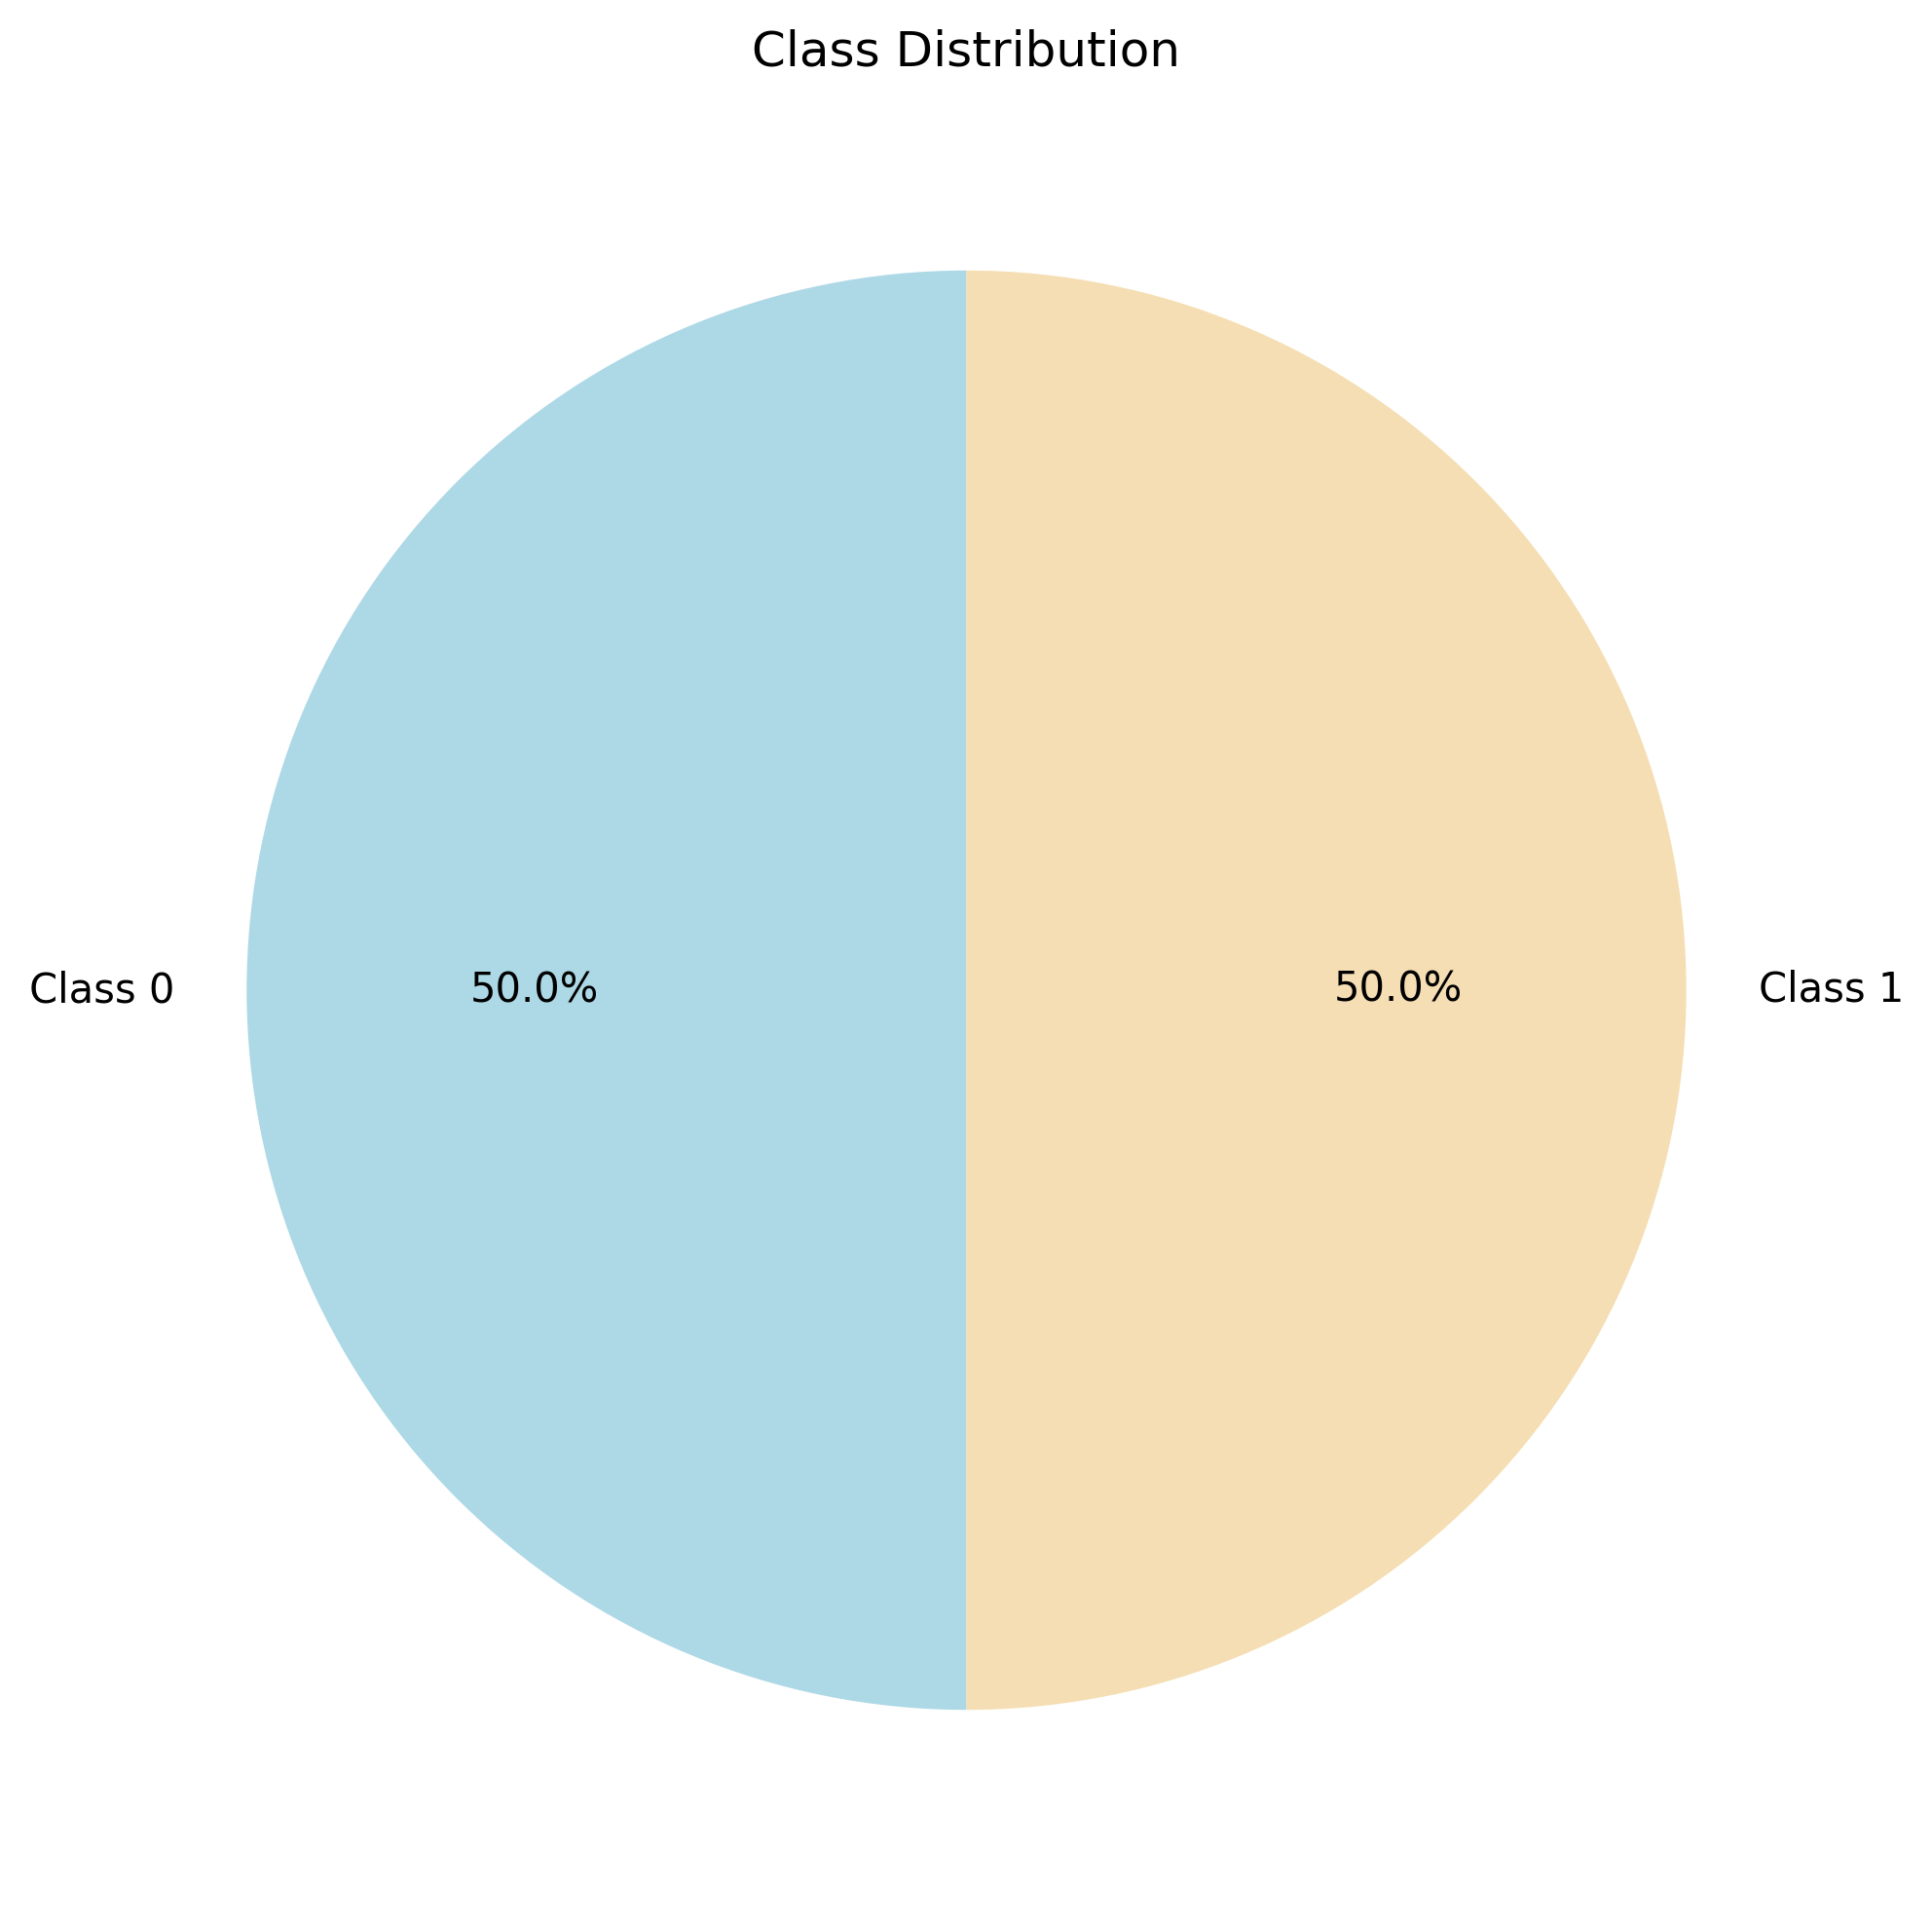

In [7]:
import matplotlib.pyplot as plt
# Extract class labels and counts
class_labels = list(class_counts.keys())
class_values = list(class_counts.values())

colors = ["lightblue" if label == 0 else "#F5DEB3" for label in class_labels]

# Create a pie chart
plt.figure(figsize=(8, 8), dpi=300)
plt.pie(
    class_values,
    labels=[f"Class {label}" for label in class_labels],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors
)
plt.title("Class Distribution")
plt.show()

## Calculate metrics for different models.

In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from scr.pytorch_model_defs import WaterPlasticModel
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [2]:
# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
# test_images, test_labels = load_data_from_directory(test_dir)


selected_bands = None # For all 12 bands
# selected_bands = [1,2,3] # For RGB
# selected_bands = [1,2,3, 9] # For RGB + NIR

train_dataset = ImageDataset(train_images, train_labels, transform=None, selected_bands=selected_bands)
val_dataset = ImageDataset(val_images, val_labels, transform=None, selected_bands=selected_bands)
# test_dataset = ImageDataset(test_images, test_labels, transform=None, selected_bands=selected_bands)


BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle only for training
    num_workers=4,      # Adjust based on your system
    pin_memory=True     # Speeds up GPU transfer if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Typically no shuffle for validation
    num_workers=4,
    pin_memory=True
)

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,      # Typically no shuffle for test
#     num_workers=4,
#     pin_memory=True
# )


In [3]:
# model = torch.load('models/pytorch_models/rgb_nir_100_epochs_classweights_augmentations.pth', weights_only=False)
# model = torch.load('models/pytorch_models/rgb_100_epochs_classweights_augmentations.pth', weights_only=False)
# model = torch.load('models/pytorch_models/100_epochs_classweights_augmentations.pth', weights_only=False)
# model = torch.load('models/pytorch_models/100_epochs_classweights.pth', weights_only=False)
model = torch.load('models/pytorch_models/100_epochs_default.pth', weights_only=False)

Accuracy: 0.9947
F1 Score: 0.9894


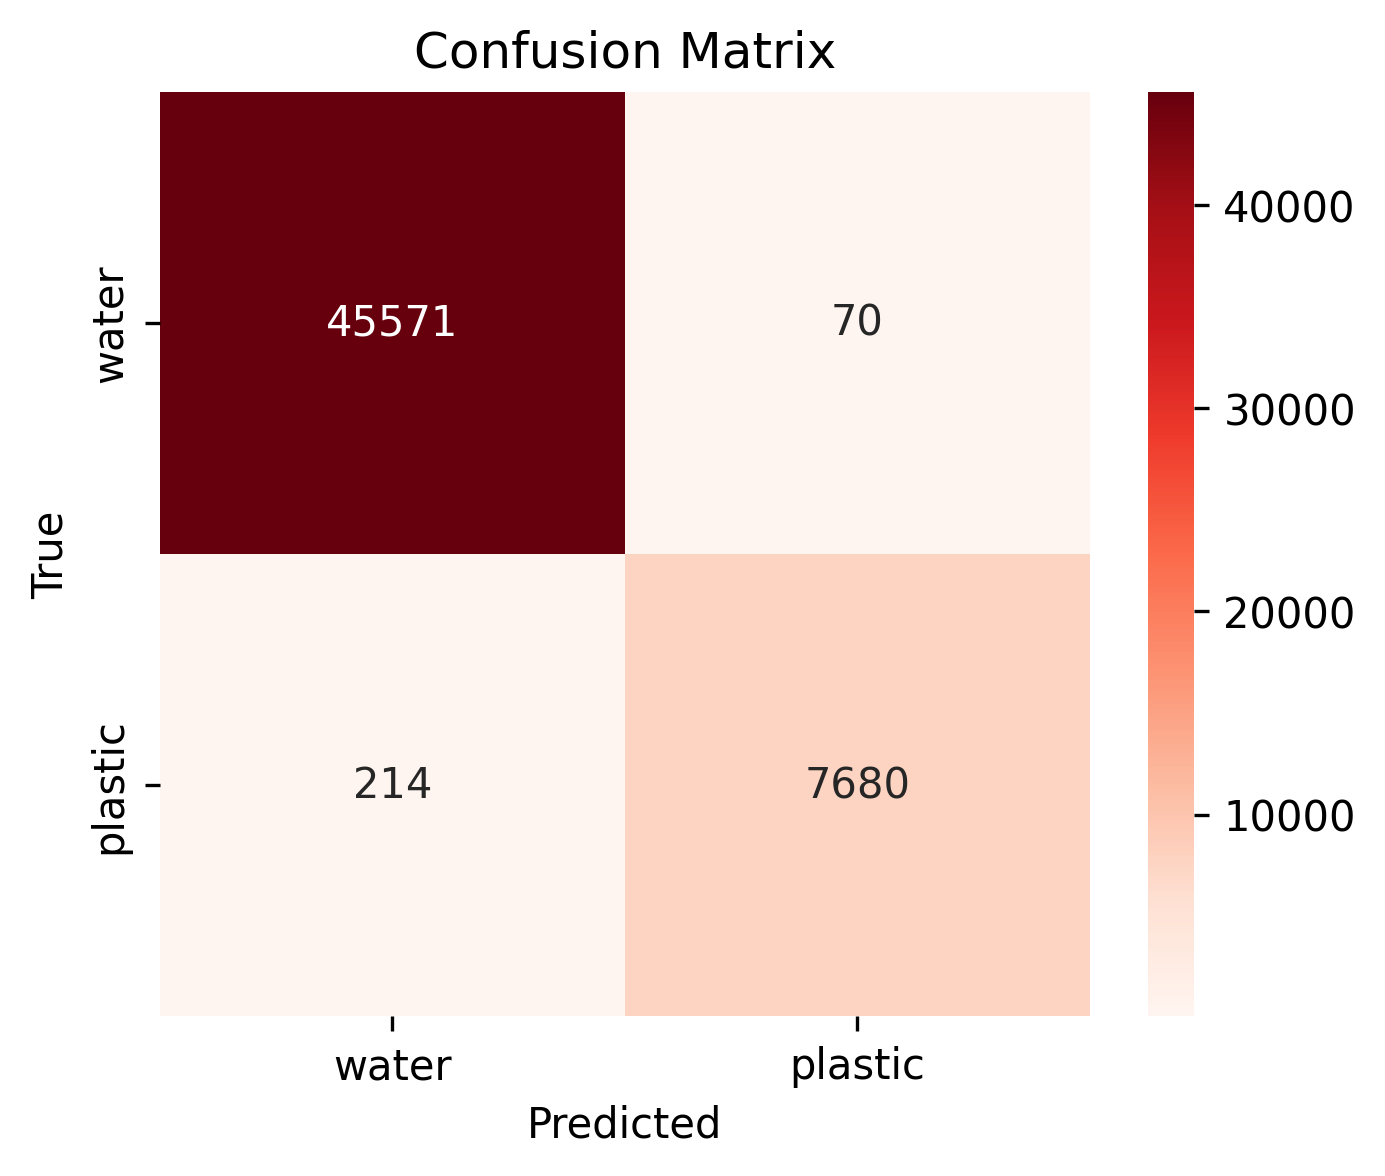

In [5]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Move the batch to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
all_preds = []
all_labels = []

# Collect all predictions and labels
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move preds & labels to CPU numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')  # Use 'macro' if you prefer

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally define class names (for a 2-class problem, e.g., water/plastic)
class_names = ["water", "plastic"]

# Plot confusion matrix
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(
    cm, 
    annot=True,       # Show numbers in cells
    fmt='d',          # Integer formatting
    cmap='Reds', 
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
